
# Introduction :

---

Ce projet s'intéresse à l'analyse des données satellites et des mesures in-situ du pCO2, collectées sur une période de 20 à 30 ans, représentant environ 500 000 observations. Les données, stratifiées par latitude, contiennent de nombreuses incertitudes et du bruit, ce qui complique leur interprétation. En raison d'une proportion élevée de valeurs manquantes, il est crucial d'adopter une stratégie d'imputation plutôt que de supprimer ces valeurs, afin de préserver l'intégrité des informations disponibles. Les variables principales incluent les concentrations de pCO2, les coordonnées géographiques (latitude et longitude), ainsi que d'autres facteurs environnementaux potentiellement influents, tels que la température et la salinité. L'objectif de ce projet est de développer un modèle d'imputation robuste qui permettra d'estimer les valeurs manquantes et de garantir que l'échantillonnage reflète fidèlement la distribution globale des données, tout en minimisant l'impact des incertitudes et du bruit présents dans le dataset.

 Voici une description des variables qui constitue notre dataset:

- DATE : Date de l'observation.

- LAT (Latitude) : Position géographique de l'observation sur l'axe nord-sud, exprimée en degrés (de -90 à 90).

- LON (Longitude) : Position géographique de l'observation sur l'axe est-ouest, exprimée en degrés (de -180 à 180).

- pCO2w : Pression partielle du CO2 dissous dans l'eau de mer.

- SST (Sea Surface Temperature) : Température de surface de la mer, mesurée en degrés Celsius (°C).

- SSS (Sea Surface Salinity) : Salinité de surface de la mer .

- Chla (Chlorophyll-a) : Concentration de chlorophylle-a.

- aCDOM (Absorption Coefficient of Colored Dissolved Organic Matter) : Coefficient d'absorption de la matière organique dissoute colorée.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Lecture du fichier

In [ ]:
import pandas as pd

# Charger le fichier Excel
df = pd.read_excel('pCO2_Dataset.xlsx')

In [ ]:

# Afficher les premières lignes du dataset
print(df.head())



       DATE        LAT        LON      pCO2w    SST        SSS     Chla   \
0  19970916  49.180000 -133.47000  317.15253  16.15  32.495998 -0.442036   
1  19970916  49.009998 -131.14999  312.06076  17.08  32.487000 -0.563070   
2  19970916  48.990002 -130.97000  321.26727  17.16  32.333000 -0.558054   
3  19970916  43.342999 -126.50000  323.05075  18.15  31.799999 -0.274361   
4  19970920  43.000000 -126.61000  332.33185  18.50  31.860001 -0.570405   

      aCDOM  
0 -1.631763  
1 -1.806464  
2 -1.751414  
3 -1.571059  
4 -1.637942  


La date sert ici de clé pour identifier nos individus, ce n'est un facteur principal agissant sur pCO2w.

In [ ]:
df = df.drop(columns=['DATE'])


In [ ]:
# Afficher les premières lignes du dataset
print(df.head())

         LAT        LON      pCO2w    SST        SSS     Chla      aCDOM
0  49.180000 -133.47000  317.15253  16.15  32.495998 -0.442036 -1.631763
1  49.009998 -131.14999  312.06076  17.08  32.487000 -0.563070 -1.806464
2  48.990002 -130.97000  321.26727  17.16  32.333000 -0.558054 -1.751414
3  43.342999 -126.50000  323.05075  18.15  31.799999 -0.274361 -1.571059
4  43.000000 -126.61000  332.33185  18.50  31.860001 -0.570405 -1.637942


# Sampling

On a plus de 500000 observations, les temps de calcul sont donc beaucoup trop longs.  Nous allons donc effectuer un sampling pour diminuer notre nombre de données, et donc notre temps de calcul en minimisant la perte d'informations. Afin de vérifier cela, il faudra s'assurer que la distribution reste quasiment inchangée avant et après le sampling. On remarque que la pression partielle du CO2 est stratifiée sur la lattitude d'après la carte présentée en cours. On va donc effectuer un échantillonnage selon la lattitude, en ne prenant que 10% des valeurs par tranche de lattitudes.


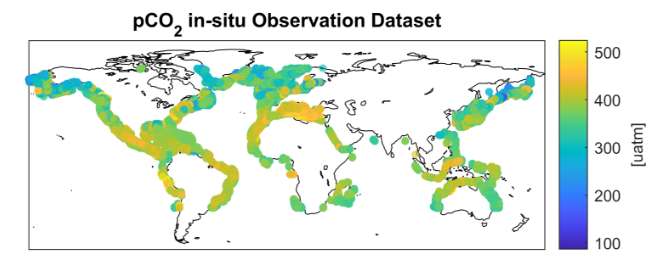

# Distribution des données avant le sampling selon la lattitude

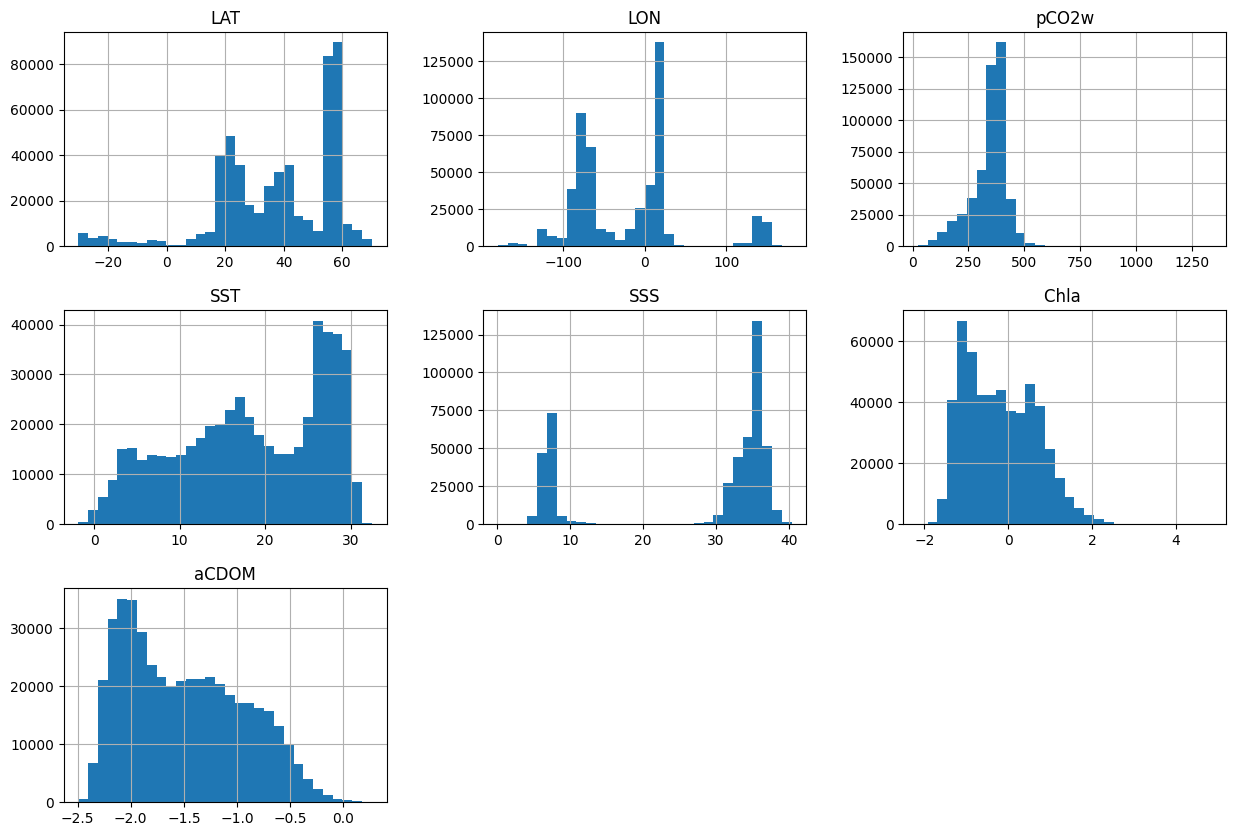

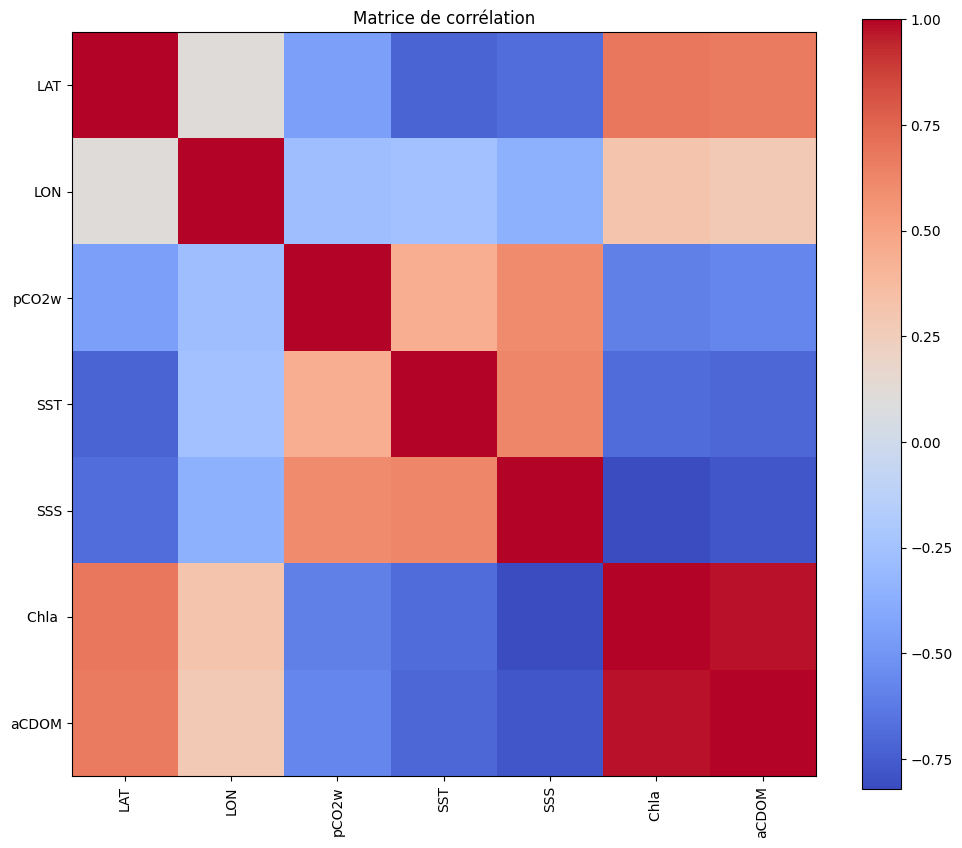

In [ ]:
# prompt: Afficher distribution des données

# Distribution des variables numériques
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Matrice de corrélation
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matrice de corrélation')
plt.show()


# Sampling

In [ ]:
# prompt: Effectuer un sampling des données selon LAT

# Sampling basé sur la longitude (LAT)
# Supposons que vous souhaitez échantillonner 10% des données pour chaque intervalle de lattitude

# Définir les intervalles de longitude (ajuster selon vos besoins)
lat_intervals = np.arange(df['LAT'].min(), df['LAT'].max() + 1, 1)

sampled_df = pd.DataFrame()
for i in range(len(lat_intervals) - 1):
  start_lat = lat_intervals[i]
  end_lat = lat_intervals[i+1]
  subset = df[(df['LAT'] >= start_lat) & (df['LAT'] < end_lat)]
  if not subset.empty:
    sample_size = int(len(subset) * 0.1)  # Ajuster le pourcentage de sampling si nécessaire
    sampled_subset = subset.sample(n=sample_size, random_state=42)  # Utiliser random_state pour la reproductibilité
    sampled_df = pd.concat([sampled_df, sampled_subset])

print(sampled_df)

              LAT         LON      pCO2w        SST        SSS     Chla   \
214564 -29.290001  153.460010  380.70938  20.201000  35.528999  0.256124   
214590 -29.437000  154.140000  325.78989  21.820999  35.561001 -0.969975   
390519 -29.466000  153.560000  334.46906  20.450001  35.651001 -0.220928   
272809 -29.372999  153.570010  316.17950  19.870001  34.792999  0.113329   
242099 -30.059999   14.782000  385.25464  14.222000        NaN -0.262653   
...           ...         ...        ...        ...        ...       ...   
302792  69.885002  -55.509998  281.57605   6.160000        NaN -0.151943   
143267  70.041000   14.890000  302.99777   7.880000  34.872002  0.029094   
119214  70.049004    8.716000  311.64612   7.260000  35.192001 -0.299467   
302796  69.846001  -59.119999  299.73929   4.750000        NaN -0.656143   
143149  70.082001   20.215000  332.76083   4.070000  34.179001 -0.631981   

           aCDOM  
214564 -0.830975  
214590 -1.910095  
390519 -1.363123  
272809 -0.9

# Distribution des données après le sampling selon la lattitude

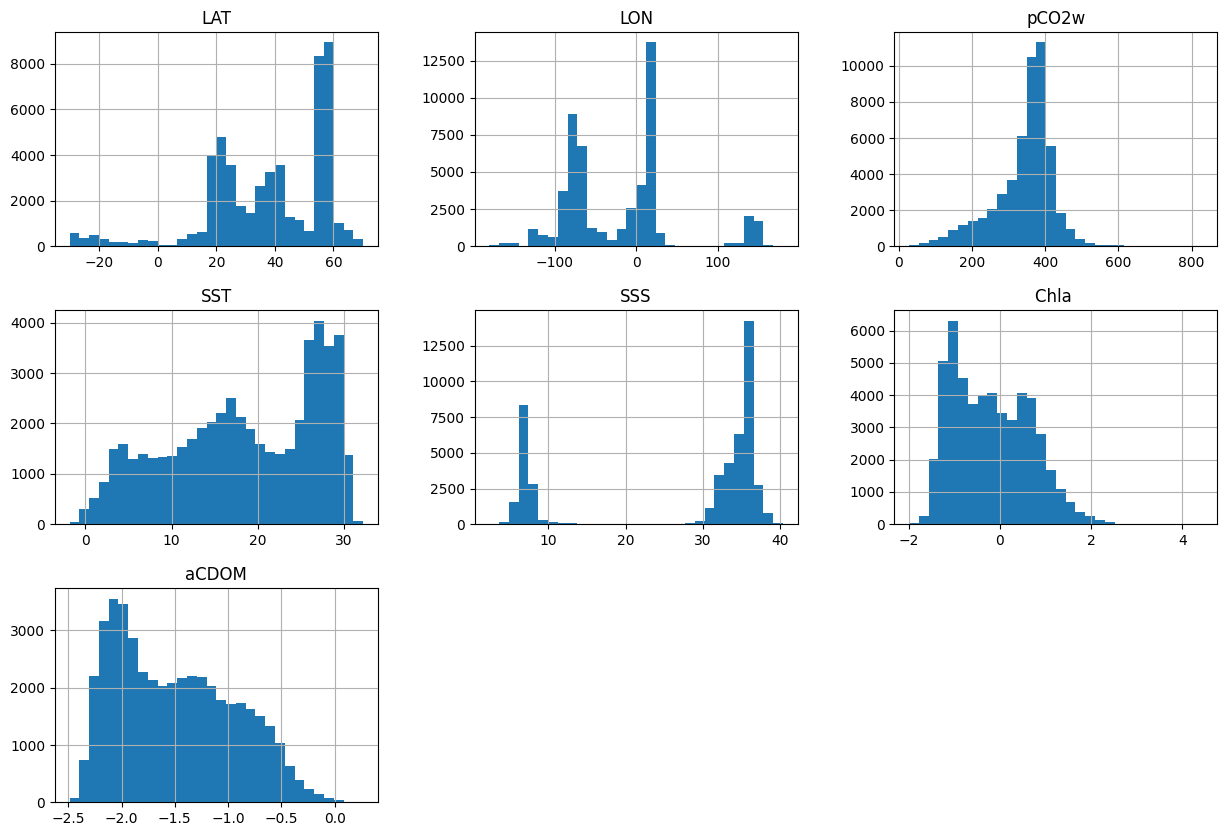

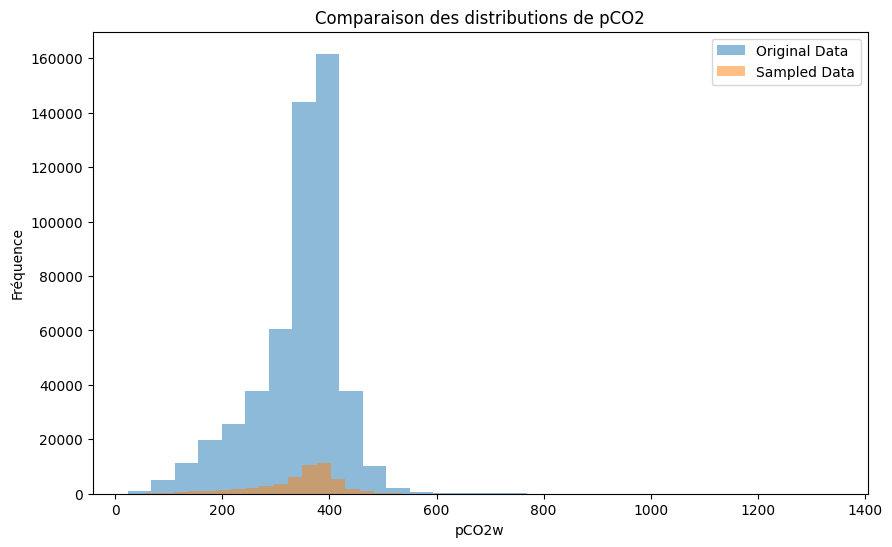

Statistique KS: nan, Valeur p: nan


In [ ]:
# prompt: Vérifier que la distribution est inchangée

# Distribution des variables numériques après le sampling
sampled_df.hist(bins=30, figsize=(15, 10))
plt.show()

# Comparer les distributions avant et après le sampling
# Par exemple, pour la variable 'pCO2':
plt.figure(figsize=(10, 6))
plt.hist(df['pCO2w'], bins=30, alpha=0.5, label='Original Data')
plt.hist(sampled_df['pCO2w'], bins=30, alpha=0.5, label='Sampled Data')
plt.xlabel('pCO2w')
plt.ylabel('Fréquence')
plt.title('Comparaison des distributions de pCO2')
plt.legend()
plt.show()

# Vous pouvez répéter cette comparaison pour d'autres variables numériques
# pour vérifier si les distributions sont similaires avant et après le sampling.

# Vous pouvez également utiliser des tests statistiques pour vérifier
# si les distributions sont significativement différentes.
# Par exemple, un test de Kolmogorov-Smirnov peut être utilisé pour comparer
# les distributions de deux échantillons.

# Exemple de test de Kolmogorov-Smirnov pour la variable 'pCO2':
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(df['pCO2w'], sampled_df['pCO2w'])
print(f"Statistique KS: {statistic}, Valeur p: {p_value}")

# Si la valeur p est supérieure à un seuil alpha (par exemple, 0.05),
# on ne peut pas rejeter l'hypothèse nulle que les deux distributions sont identiques.
# Cela signifie que les distributions de pCO2 avant et après le sampling sont similaires.

La distribution après le sampling reste bien quasiment inchangée. On se retrouve donc avec 51799 données au lieu des 500000, ce qui diminue largement les temps de calculs.

In [ ]:
# Afficher toutes les colonnes
print(sampled_df.columns)

Index(['LAT', 'LON', 'pCO2w', 'SST', 'SSS', 'Chla ', 'aCDOM'], dtype='object')


In [ ]:
# Afficher un aperçu du dataset pour comprendre les colonnes et types de données
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51799 entries, 214564 to 143149
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LAT     51799 non-null  float64
 1   LON     51799 non-null  float64
 2   pCO2w   51777 non-null  float64
 3   SST     51777 non-null  float64
 4   SSS     47173 non-null  float64
 5   Chla    51799 non-null  float64
 6   aCDOM   45369 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [ ]:
sampled_df.shape

(51799, 7)

On enlève la lattitude et la longitude et on se concentre sur les 4 variables explicatives:

- SST : Température de la surface de la mer
- SSS : Salinité de la surface de la mer
- Chla : Concentration de chlorophille
- aCDOM : Coefficient d'absorbation de la matière organique dissoute colorée

La varaible cible est:

- pCO2w : Pression partielle du CO2 dissout dans l'eau de mer


In [ ]:
sampled_df = sampled_df.drop(columns=['LAT'])
sampled_df = sampled_df.drop(columns=['LON'])


# Définir les variables explicatives (X) et la variable cible (y)
X = sampled_df[['SST', 'SSS', 'Chla ', 'aCDOM']]  # Ajustez les noms des colonnes si nécessaire
y = sampled_df['pCO2w']  # Variable cible

# Afficher les premières lignes pour vérifier
print("X (variables explicatives) :\n", X.head())
print("\nY (variable cible pCO2w ) :\n", y.head())


X (variables explicatives) :
               SST        SSS     Chla      aCDOM
214564  20.201000  35.528999  0.256124 -0.830975
214590  21.820999  35.561001 -0.969975 -1.910095
390519  20.450001  35.651001 -0.220928 -1.363123
272809  19.870001  34.792999  0.113329 -0.940175
242099  14.222000        NaN -0.262653 -1.578273

Y (variable cible pCO2w ) :
 214564    380.70938
214590    325.78989
390519    334.46906
272809    316.17950
242099    385.25464
Name: pCO2w, dtype: float64


In [ ]:
X.shape

(51799, 4)

In [ ]:
y.shape

(51799,)

# Traitement des NaN

On vérifie si notre jeu de données comprend des NaN.

In [ ]:
# Vérifier le nombre total de NaN dans le DataFrame
total_nan = X.isnull().sum().sum()

# Calculer le nombre total de valeurs dans le DataFrame
total_values = X.size

# Calculer la proportion de NaN
proportion_nan = total_nan / total_values * 100

# Afficher les résultats
print(f"Nombre total de NaN dans le sampling dataset : {total_nan}")
print(f"Proportion de NaN dans le sampling dataset : {proportion_nan:.2f}%")


Nombre total de NaN dans le sampling dataset : 11078
Proportion de NaN dans le sampling dataset : 5.35%


On remarque qu'il y a un nombre important de NaN (11078) qui représente 5.35% des données samplées.
On doit donc trouver une méthode d'imputation adéquate pour remplacer ces NaN de sorte à minimiser la perte d'informations.



On voit sur matrices de corrélations que seulement 2 variables sont vraiment
corrélées: Chla/LAT et Acdom/LAT. Les autres ne sont que moyennement corrélées ou pas du tout. On ne va pas effectuer de régression linéaire ou stochastique pour nos valeurs manquantes car les relations entre nos variables non-linéaires. On va ici tester des méthodes d'imputation qui permettent de capturer les relations complexes entre les variables comme:
- La méthode des forêts aléatoire (Random Forest)
- La méthode des K plus proches voisins (KNN)

# Imputation avec Random Forest

L'imputation avec Random Forest consiste à entraîner un modèle sur les lignes sans valeurs manquantes en utilisant les variables explicatives pour prédire la variable cible. Une fois le modèle entraîné, il est utilisé pour estimer les valeurs manquantes dans la variable cible, en se basant sur les relations apprises entre les variables explicatives, qui sont elles-mêmes remplies avec la médiane.

In [ ]:

import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Sélectionner les colonnes pour l'imputation
features = ['SST', 'SSS', 'Chla ', 'aCDOM']
target = 'pCO2w'

# Créer une copie du DataFrame pour éviter de modifier l'original
df_copy_r = sampled_df.copy()  # Assurez-vous que df est défini avant cela

# Remplir les NaN dans les variables explicatives avec la médiane
df_copy_r[features] = df_copy_r[features].fillna(df_copy_r[features].median())

# Séparer les lignes avec des valeurs manquantes dans la variable cible
mask = df_copy_r[target].isnull()

# Séparer les données d'entraînement (sans NaN) et de test (avec NaN)
X_train = df_copy_r[~mask][features]
y_train = df_copy_r[~mask][target]
X_test = df_copy_r[mask][features]

# Créer et entraîner le modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Imputer les valeurs manquantes dans la variable cible
df_copy_r.loc[mask, target] = rf.predict(X_test)

# Vérifier les résultats
print("Nombre de NaN dans la variable cible après imputation :", df_copy_r[target].isnull().sum())
print("Nombre de NaN dans les variables explicatives après imputation :", df_copy_r[features].isnull().sum().sum())
print("Premières lignes après imputation :\n", df_copy_r.head())



Nombre de NaN dans la variable cible après imputation : 0
Nombre de NaN dans les variables explicatives après imputation : 0
Premières lignes après imputation :
             pCO2w        SST        SSS     Chla      aCDOM
214564  380.70938  20.201000  35.528999  0.256124 -0.830975
214590  325.78989  21.820999  35.561001 -0.969975 -1.910095
390519  334.46906  20.450001  35.651001 -0.220928 -1.363123
272809  316.17950  19.870001  34.792999  0.113329 -0.940175
242099  385.25464  14.222000  34.233002 -0.262653 -1.578273


In [ ]:
# Initialiser le standard scaler
scaler = StandardScaler()

# Normaliser les données (moyenne = 0, écart-type = 1)
df_stand = pd.DataFrame(scaler.fit_transform(df_copy_r), columns=df_copy_r.columns)

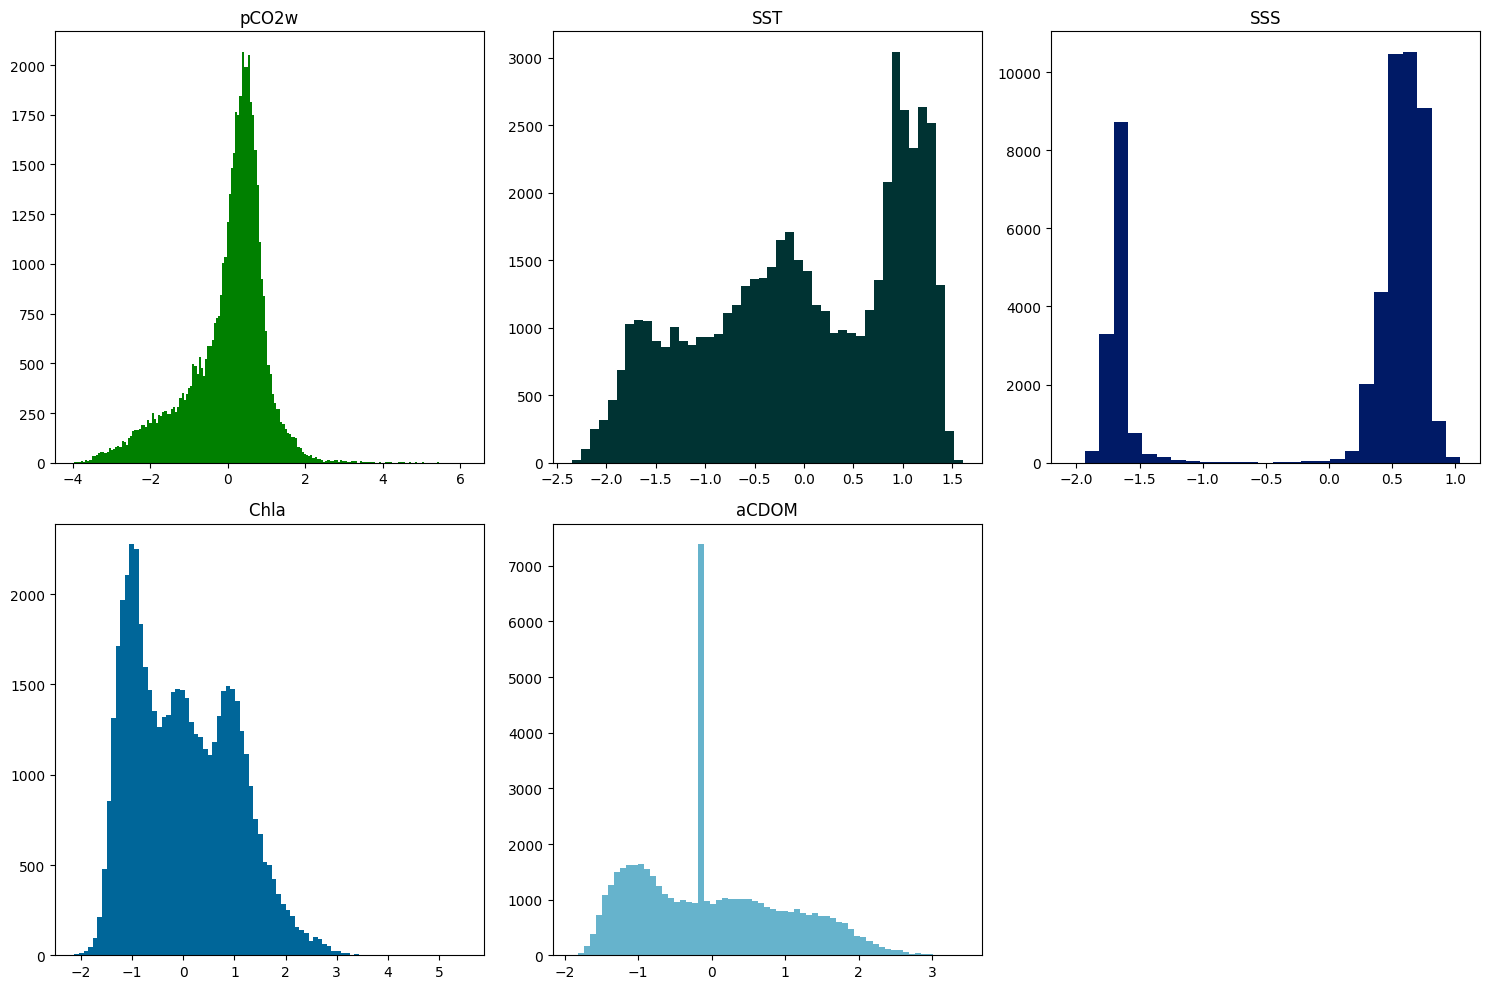

In [ ]:
import matplotlib.pyplot as plt

# Colormap
myMap = plt.get_cmap('ocean')

# Création de la figure et des sous-graphiques (2 lignes, 3 colonnes)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Création des histogrammes pour les 5 variables
for i in range(2):  # Parcourir les lignes
    for j in range(3):  # Parcourir les colonnes
        col_index = i * 3 + j  # Calculer l'index de la colonne
        if col_index < len(df_stand.columns):  # Vérifier qu'il y a bien une colonne à cet index
            axs[i, j].hist(df_stand.iloc[:, col_index], bins='auto', color=myMap(col_index / len(df_stand.columns)))
            axs[i, j].set_title(df_stand.columns[col_index])  # Ajouter un titre avec le nom de la colonne
        else:
            axs[i, j].axis('off')  # Désactiver l'affichage si aucun histogramme n'est prévu pour cet emplacement

# Ajustement de la mise en page pour éviter les chevauchements
fig.tight_layout()

# Afficher les histogrammes
plt.show()


On remarque que la distribution des données suite à l'application de l'imputation ne ressemble plus à sa distribution initiale. Sur la variable aCDOM, on voit que certaines beaucoup trop représentées par rapport à la distribution initiale. En effet, la méthode de random forest peu être parfois très sensible aux variations des données et produit des distributions de sorties qui diffèrent des distribution originales.

# imputation  avec KNN

L'imputation avec KNN consiste à identifier, pour chaque valeur manquante, les K lignes les plus proches (voisins) qui n'ont pas de valeurs manquantes, en se basant sur les autres variables. Ensuite, la valeur manquante est remplacée par la moyenne des valeurs des voisins pour cette variable

In [ ]:
# Créer une copie du DataFrame pour éviter de modifier l'original
df_copy_k = sampled_df.copy()  # Assurez-vous que df est défini avant cela

features = ['pCO2w','SST', 'SSS', 'Chla ', 'aCDOM']

# Initialiser l'imputer KNN avec k=5 (par défaut)
imputer = KNNImputer(n_neighbors=5)

# Appliquer l'imputation KNN aux colonnes sélectionnées
df_copy_k = pd.DataFrame(imputer.fit_transform(df_copy_k), columns=features)

# Vérifier les résultats
print("Nombre de NaN après imputation :\n", df_copy_k.isnull().sum())
print("\nPremières lignes du dataset après imputation :\n", df_copy_k.head())

Nombre de NaN après imputation :
 pCO2w    0
SST      0
SSS      0
Chla     0
aCDOM    0
dtype: int64

Premières lignes du dataset après imputation :
        pCO2w        SST        SSS     Chla      aCDOM
0  380.70938  20.201000  35.528999  0.256124 -0.830975
1  325.78989  21.820999  35.561001 -0.969975 -1.910095
2  334.46906  20.450001  35.651001 -0.220928 -1.363123
3  316.17950  19.870001  34.792999  0.113329 -0.940175
4  385.25464  14.222000  34.162000 -0.262653 -1.578273


In [ ]:
# Initialiser le standard scaler
scaler = StandardScaler()

# Normaliser les données (moyenne = 0, écart-type = 1)
df_stand = pd.DataFrame(scaler.fit_transform(df_copy_k), columns=df_copy_k.columns)

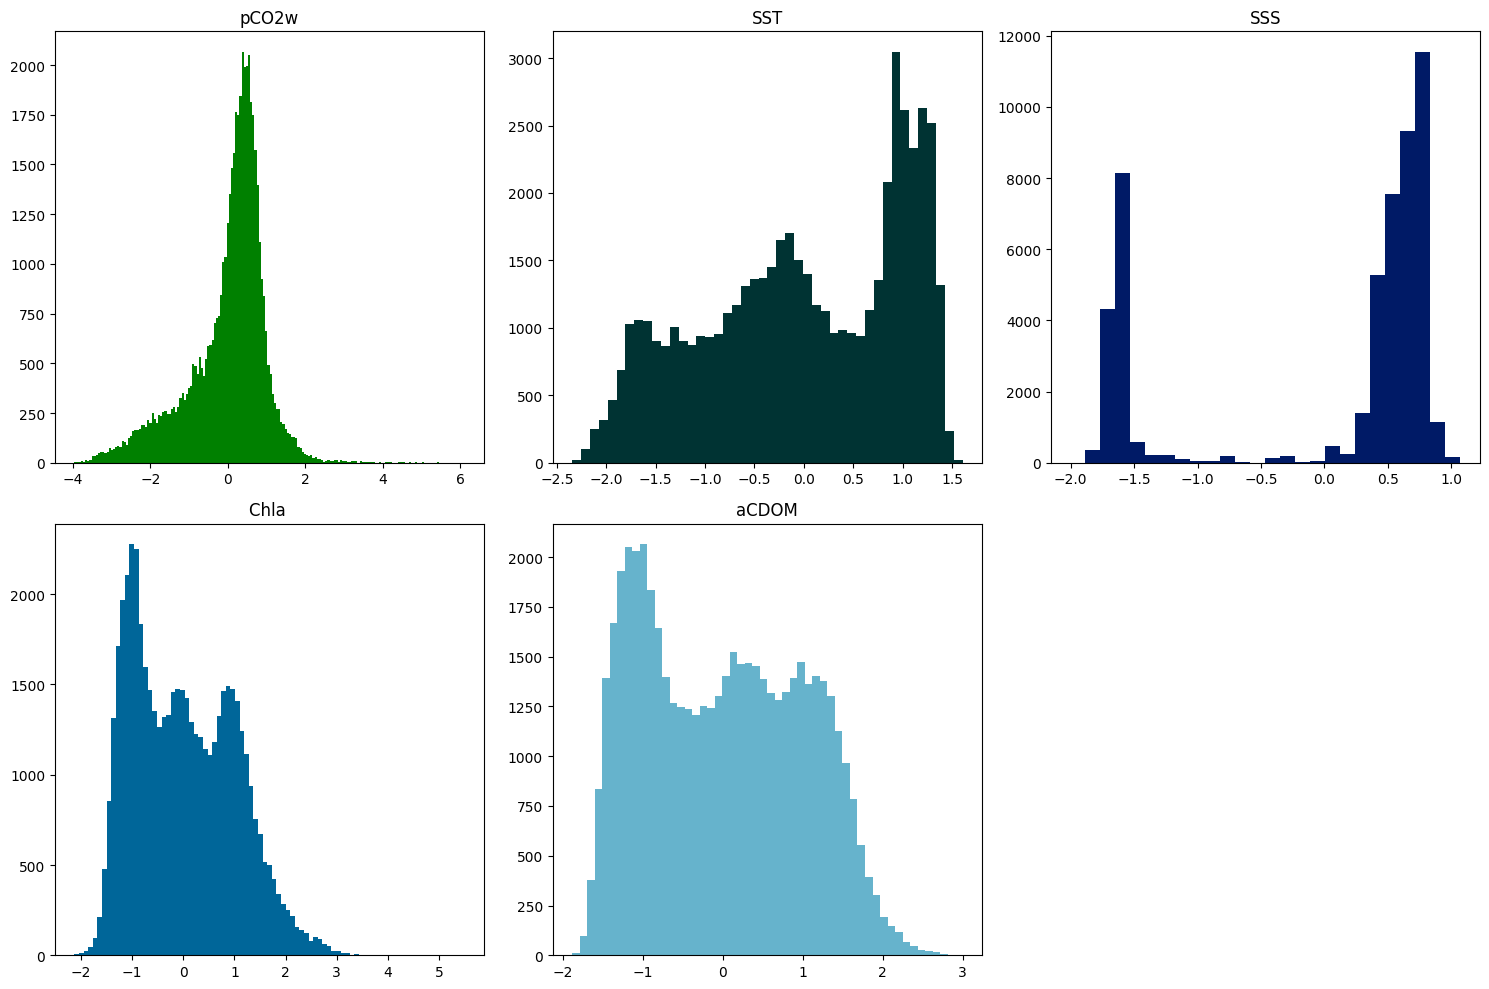

In [ ]:
import matplotlib.pyplot as plt

# Colormap
myMap = plt.get_cmap('ocean')

# Création de la figure et des sous-graphiques (2 lignes, 3 colonnes)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Création des histogrammes pour les 5 variables
for i in range(2):  # Parcourir les lignes
    for j in range(3):  # Parcourir les colonnes
        col_index = i * 3 + j  # Calculer l'index de la colonne
        if col_index < len(df_stand.columns):  # Vérifier qu'il y a bien une colonne à cet index
            axs[i, j].hist(df_stand.iloc[:, col_index], bins='auto', color=myMap(col_index / len(df_stand.columns)))
            axs[i, j].set_title(df_stand.columns[col_index])  # Ajouter un titre avec le nom de la colonne
        else:
            axs[i, j].axis('off')  # Désactiver l'affichage si aucun histogramme n'est prévu pour cet emplacement

# Ajustement de la mise en page pour éviter les chevauchements
fig.tight_layout()

# Afficher les histogrammes
plt.show()

En utilisant l'imputation avec KNN, on remarque que la distribution des données reste inchangée par rapport à l'échantillonnage initial. Pour cette raison, nous conservons cette méthode d'imputation pour les étapes suivantes de modélisation.

# Etude unidimensionnelle

Le but de l'étude unidimensionnelle est d'observer la répartition des données selon chaque variable.

In [ ]:
df_copy_k[features].describe()

,pCO2w,SST,SSS,Chla,aCDOM
count,51799.000000,51799.000000,51799.000000,51799.000000,51799.000000
mean,344.001133,18.372916,27.140034,-0.192613,-1.424753
std,79.598268,8.620951,12.386154,0.842981,0.564243
min,28.918219,-1.840000,2.330000,-1.989264,-2.488392
25%,310.520095,11.740000,8.350000,-0.942547,-1.945100
50%,363.269530,18.790001,33.890999,-0.276491,-1.436170
75%,392.643110,26.500000,36.009998,0.484148,-0.945741
max,830.160890,32.222000,40.412998,4.444844,0.267043


On remarque que l'écart-type est très différent d'une variable à une autre ,on va donc par la suite normaliser nos données.

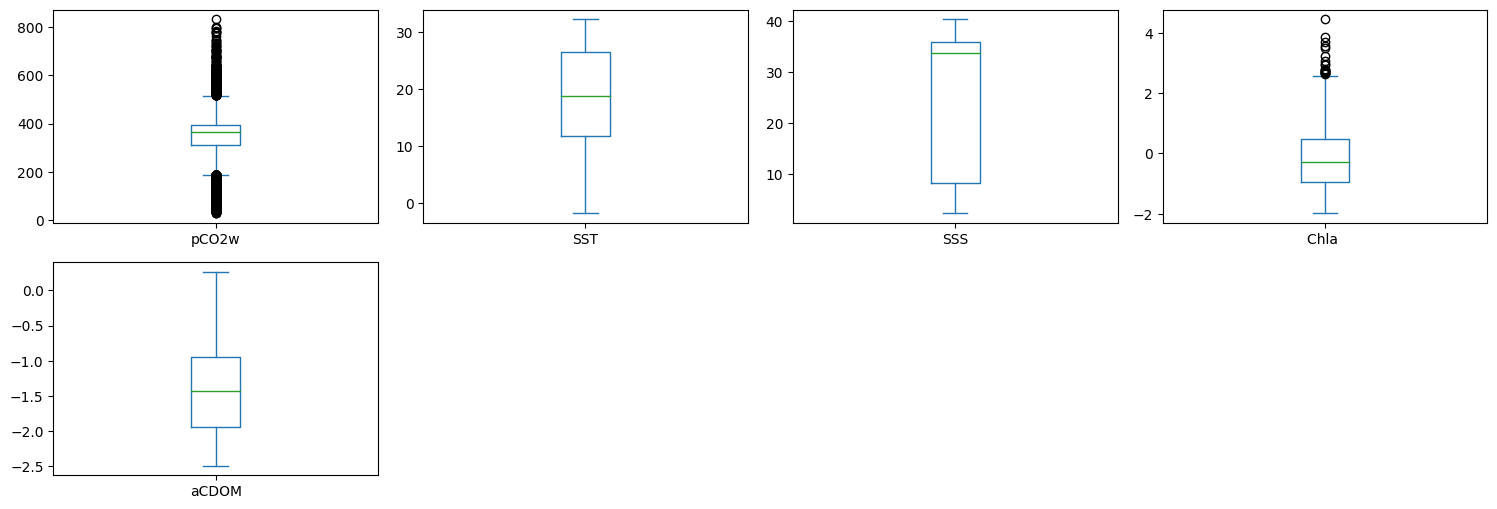

In [ ]:
# Création des boxplots pour chaque variable numérique
df_copy_k[features].plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 10))
plt.tight_layout()
plt.show()

En analysant les boxplots, on remarque que les  variable pCO2w et Chla présentent des outliers significatifs, ce qui pourrait indiquer des observations atypiques ou des conditions environnementales particulières.

SST, SSS, et aCDOM semblent plus symétriques et moins affectées par des valeurs extrêmes.

In [ ]:
# Initialiser le standard scaler
scaler = StandardScaler()

# Normaliser les données (moyenne = 0, écart-type = 1)
df_stand = pd.DataFrame(scaler.fit_transform(df_copy_k), columns=df_copy_k.columns)

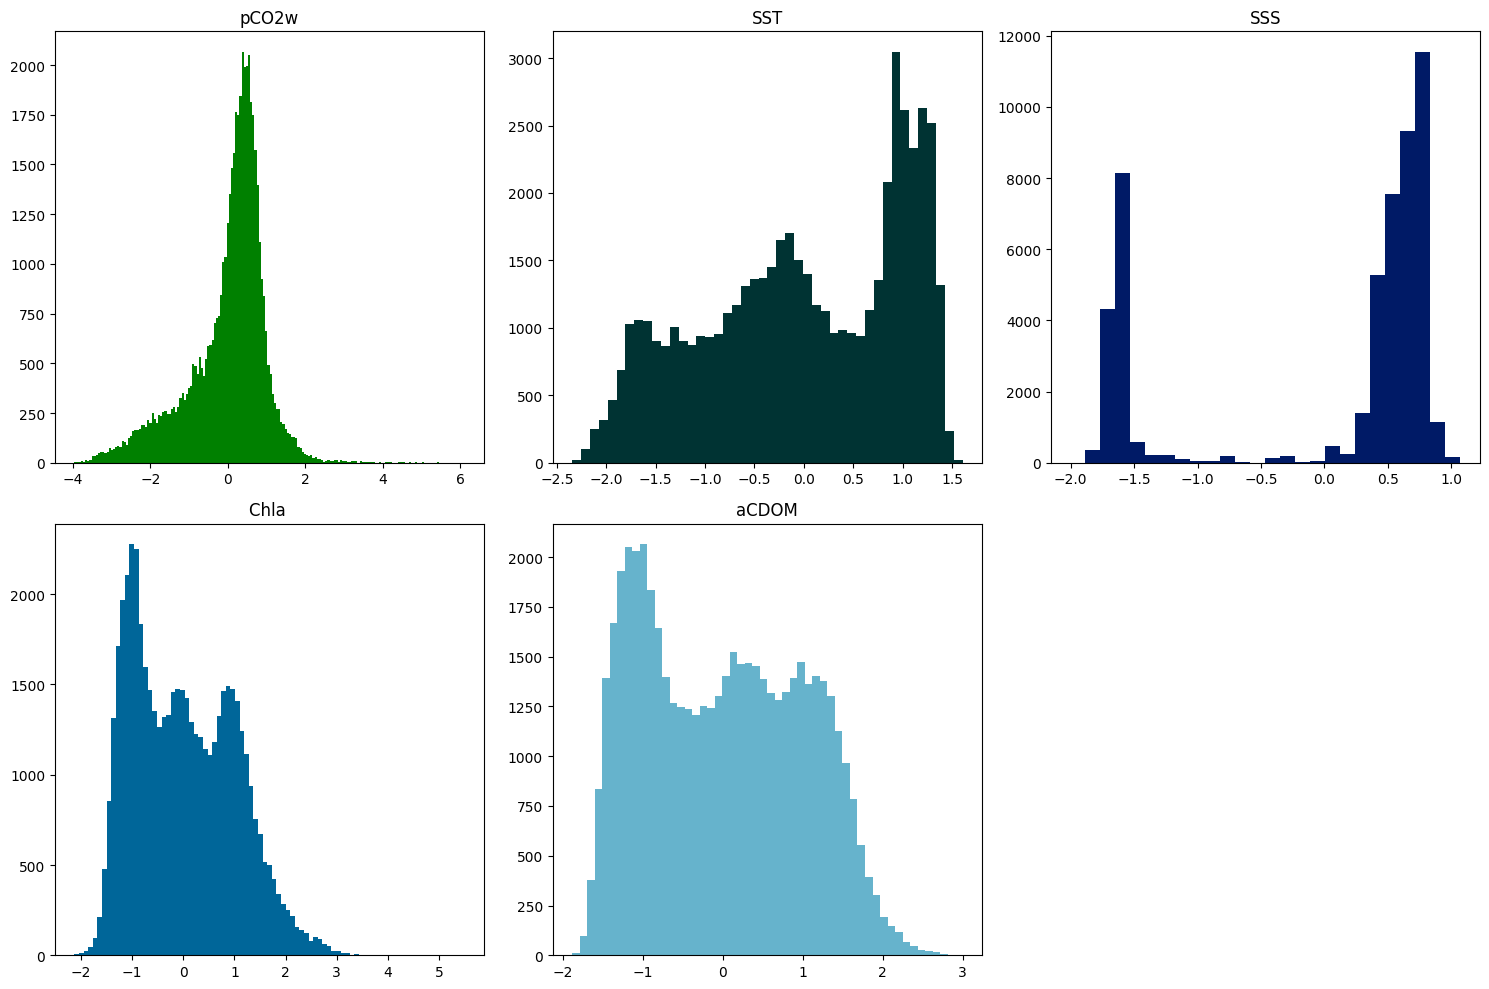

In [ ]:
import matplotlib.pyplot as plt

# Colormap
myMap = plt.get_cmap('ocean')

# Création de la figure et des sous-graphiques (2 lignes, 3 colonnes)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Création des histogrammes pour les 5 variables
for i in range(2):  # Parcourir les lignes
    for j in range(3):  # Parcourir les colonnes
        col_index = i * 3 + j  # Calculer l'index de la colonne
        if col_index < len(df_stand.columns):  # Vérifier qu'il y a bien une colonne à cet index
            axs[i, j].hist(df_stand.iloc[:, col_index], bins='auto', color=myMap(col_index / len(df_stand.columns)))
            axs[i, j].set_title(df_stand.columns[col_index])  # Ajouter un titre avec le nom de la colonne
        else:
            axs[i, j].axis('off')  # Désactiver l'affichage si aucun histogramme n'est prévu pour cet emplacement

# Ajustement de la mise en page pour éviter les chevauchements
fig.tight_layout()

# Afficher les histogrammes
plt.show()


La distribution de pCO2w est symétrique et proche d'une distribution normale.

SST est fortement asymétrique, avec les données qui sont très concentrées vers les valeurs élevées.

SSS semble présenter une bimodalité, ce qui peut indiquer des groupes différents dans l'ensemble de données.

On remarque que Chla et aCDOM ont des distributions très similaires.

# Etude bidimensionnelle

L'analyse bidimensionnelle consiste à étudier simultanément les paires de variables, afin de comprendre les relations entre elles.

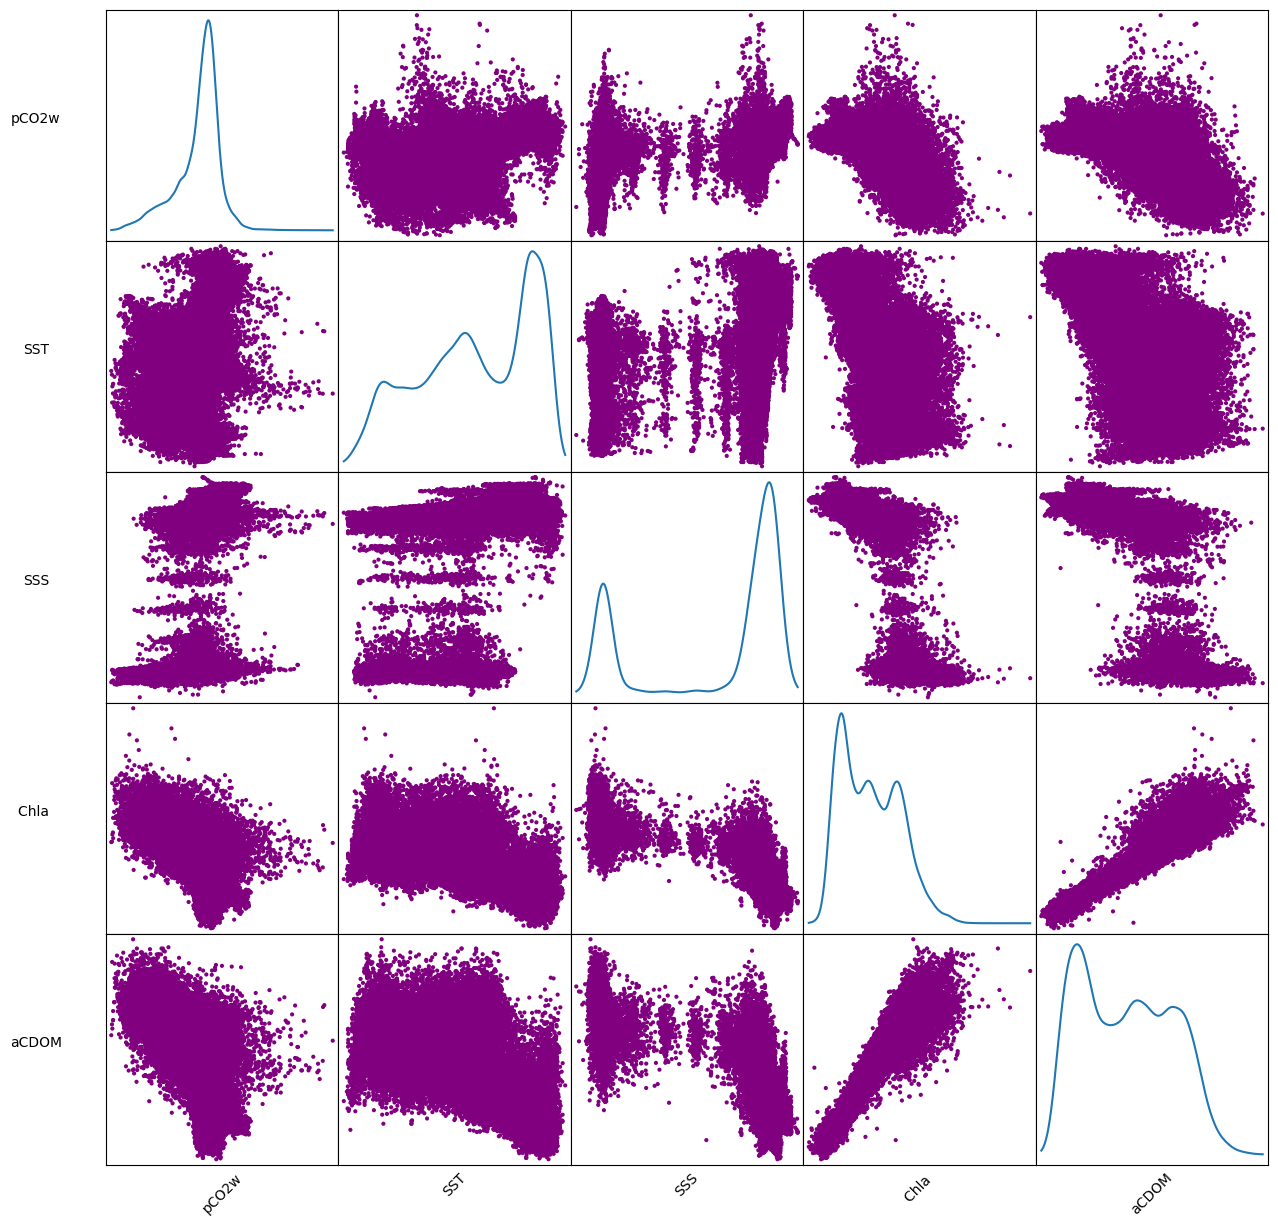

In [ ]:
sm = scatter_matrix(df_copy_k.iloc[:,0:7], alpha = 1, figsize = (15, 15), diagonal = 'kde',color="purple")
fig.tight_layout()

[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

Corrélations positives :
- Chla et aCDOM ont relation linéaire, les variables sont fortement corrélées positivement.

corrélations négatives :

- pCO2w et aCDOM
- SST et aCDOM
- Chla et pCO2w
- Chla et SST

Matrice de corrélation de Pearson :
           pCO2w       SST       SSS     Chla      aCDOM
pCO2w  1.000000  0.437909  0.579548 -0.599624 -0.589691
SST    0.437909  1.000000  0.548016 -0.692086 -0.711595
SSS    0.579548  0.548016  1.000000 -0.809080 -0.783226
Chla  -0.599624 -0.692086 -0.809080  1.000000  0.954832
aCDOM -0.589691 -0.711595 -0.783226  0.954832  1.000000

Matrice de corrélation de Spearman :
           pCO2w       SST       SSS     Chla      aCDOM
pCO2w  1.000000  0.515530  0.538165 -0.561383 -0.562132
SST    0.515530  1.000000  0.654936 -0.733026 -0.737874
SSS    0.538165  0.654936  1.000000 -0.866630 -0.852195
Chla  -0.561383 -0.733026 -0.866630  1.000000  0.970076
aCDOM -0.562132 -0.737874 -0.852195  0.970076  1.000000


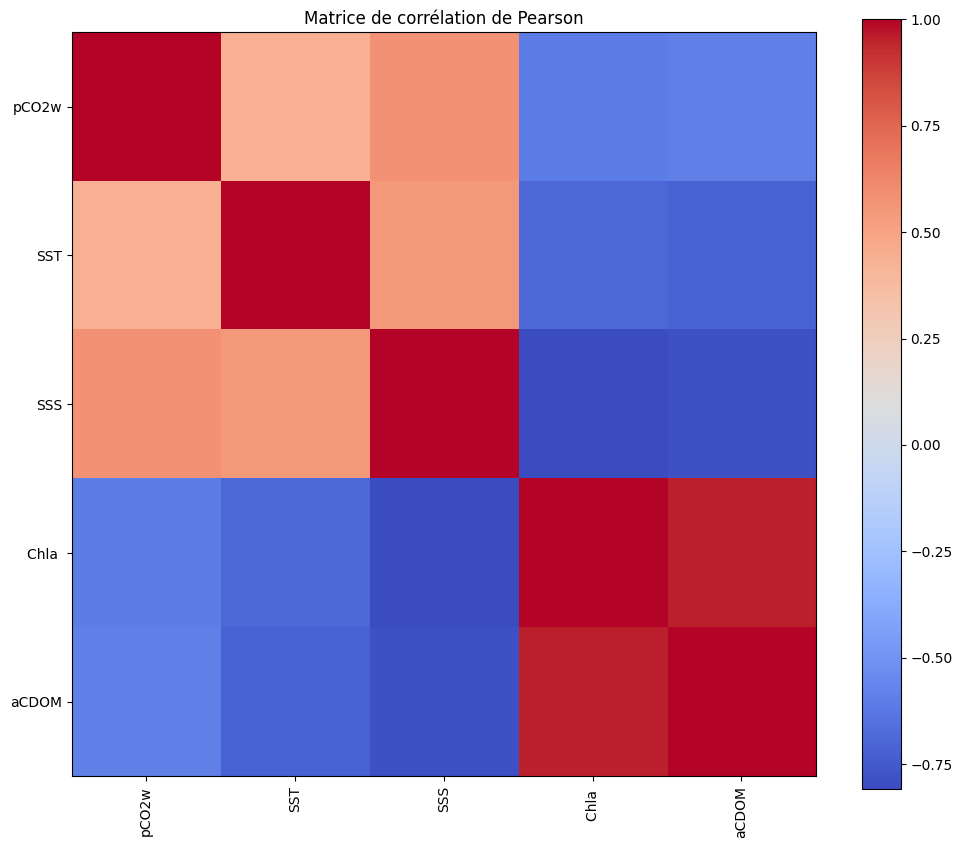

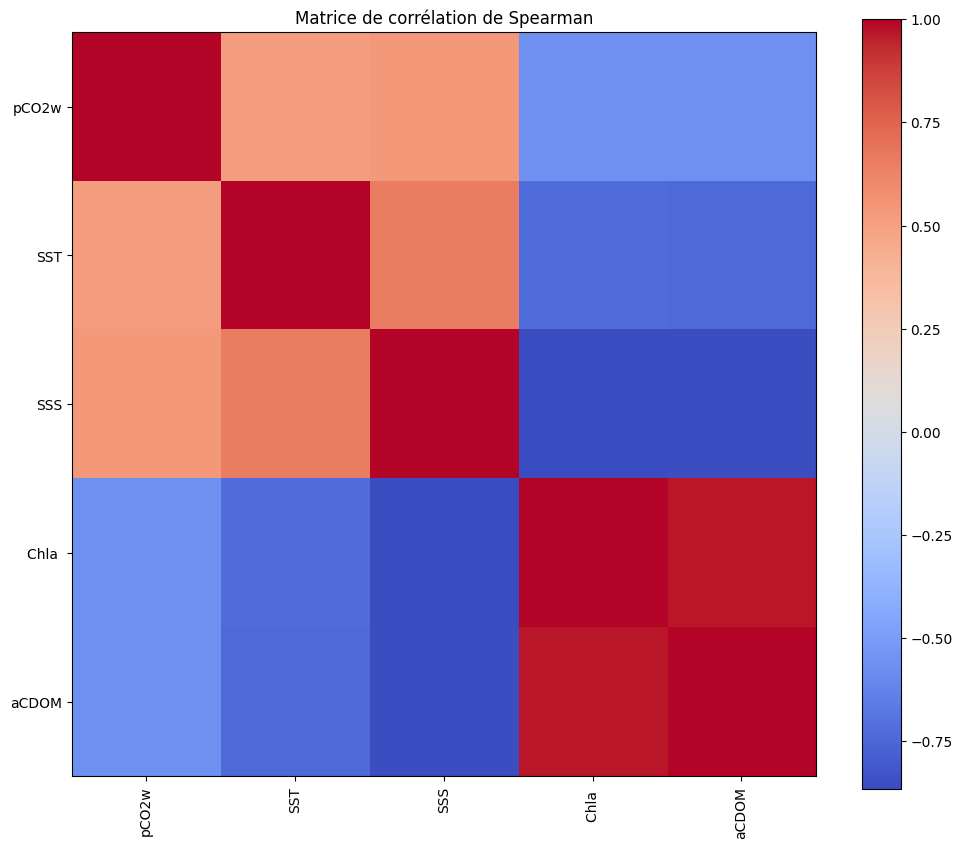

In [ ]:
# Calculer la matrice de corrélation de Pearson
correlation_matrix = df_copy_k.corr()

# Afficher la matrice de corrélation
print("Matrice de corrélation de Pearson :\n", correlation_matrix)

# Calculer la matrice de corrélation de Spearman
correlation_matrix_spearman = df_copy_k.corr(method='spearman')

# Afficher la matrice de corrélation de Spearman
print("\nMatrice de corrélation de Spearman :\n", correlation_matrix_spearman)


# Visualisation de la matrice de corrélation avec une heatmap (Pearson)
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df_copy_k.columns)), df_copy_k.columns, rotation=90)
plt.yticks(range(len(df_copy_k.columns)), df_copy_k.columns)
plt.title('Matrice de corrélation de Pearson')
plt.show()

# Visualisation de la matrice de corrélation avec une heatmap (Spearman)
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix_spearman, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df_copy_k.columns)), df_copy_k.columns, rotation=90)
plt.yticks(range(len(df_copy_k.columns)), df_copy_k.columns)
plt.title('Matrice de corrélation de Spearman')
plt.show()


Matrice des corrélations de Pearson:

- pCO2w (pression partielle de CO2 dans l’eau) a une corrélation positive avec la SSS (salinité de surface de la mer) (0.580) et la SST (température de surface de la mer) (0.438), ce qui indique qu'à mesure que la salinité et la température augmentent, la concentration de pCO2 augmente également.

- La Chla (chlorophylle a, indicateur de la concentration de phytoplancton) et aCDOM (absorbance de matière organique dissoute) montrent des corrélations négatives fortes avec pCO2w (-0.600 et -0.590, respectivement). Cela pourrait refléter des dynamiques de productivité biologique réduisant le CO2 dans l'eau.

- Il existe aussi une corrélation positive très forte entre Chla et aCDOM (0.955).

Matrice des corrélations de Spearman:

Les résultats de la corrélation de Spearman confirment globalement les relations observées avec Pearson, mais les valeurs diffèrent légèrement en raison de la nature non-linéaire de certaines relations.

Par exemple:
- la relation entre pCO2w et SST est plus forte selon Spearman (0.516 contre 0.438 avec Pearson), leur relation est donc plus monotone que strictement linéaire.
- On observe également des corrélations légèrement plus fortes entre SSS et Chla (-0.867 selon Spearman contre -0.809 pour Pearson).

# Etude multidimensionnelle

 Le but de l'étude multidimensionnelle est de comprendre les interactions complexes qui existent entre les variables. Pour cela, on va réaliser une analyse en Analyse en composantes principales (ACP).

# Analyse en composantes principales


Valeurs propres (correlation matrix):
 [3.71766948 0.58604687 0.42962985 0.22293809 0.04371571]

Pourcentage d'information (variance expliquée) par composante:
 [74.35338965 11.72093736  8.59259696  4.45876176  0.87431427]


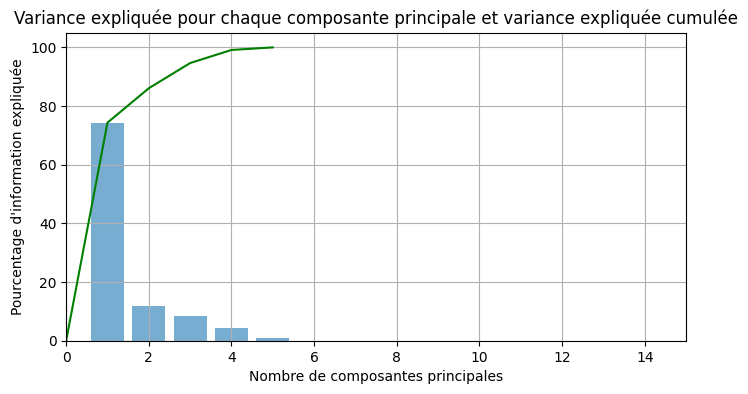

In [ ]:
##### Analyse en Composantes Principales #####

# On effectue l'analyse en composante principales
pca = PCA()
principal_components = pca.fit_transform(df_stand)

# On extrait les valeurs et vecteurs propres
eig_vals_corr, eig_vecs_corr = np.linalg.eig(np.corrcoef(df_stand.T))
print("\nValeurs propres (correlation matrix):\n", eig_vals_corr)
# print("\nVecteurs propres (correlation matrix):\n", eig_vecs_corr)

# On en déduit le pourcentage de la variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_ * 100
print("\nPourcentage d'information (variance expliquée) par composante:\n", explained_variance)

# Plot du pourcentage de la variance expliquée pour chaque composante principale
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6)
plt.plot(np.cumsum(np.array([0, *explained_variance])), color='green')
plt.xlim([0,15])
plt.grid(True)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Pourcentage d\'information expliquée')
plt.title('Variance expliquée pour chaque composante principale et variance expliquée cumulée')
plt.show()

On remarque que:

- 74.35% de la variance expliquée par la première composante.

- 86,07% de la variance expliquée par les deux premières composantes.

- 94,47% de la variance expliquée par les 3 premières composantes.

En se basant sur la règle du coude, on décide de ne garder que les deux premières composantes.



# Pour 2 composantes

On affiche le cercle de corrélations :

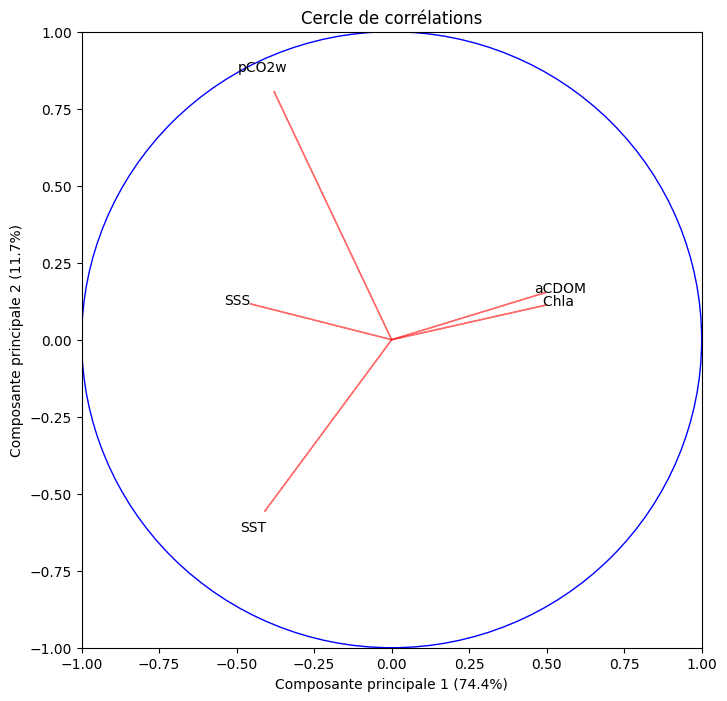

In [ ]:
# Cercle de corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

# Cercle unité
circle1 = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(circle1)

# Flèches et étiquettes des variables
for i in range(df_stand.shape[1]):
  plt.arrow(0,0, pca.components_[0,i], pca.components_[1,i], color='red', alpha=0.5)
  plt.text(pca.components_[0,i] * 1.1, pca.components_[1,i] * 1.1, df_copy_k.columns[i], color='black', ha='center', va='center')

# Titres et labels
plt.xlabel('Composante principale 1 ({}%)'.format(round(explained_variance[0], 1)))
plt.ylabel('Composante principale 2 ({}%)'.format(round(explained_variance[1], 1)))
plt.title('Cercle de corrélations')
plt.show()

In [ ]:
# prompt: Afficher tableau des corrélations des variables par rapport au deux premières composantes

# Calculer la corrélation entre les variables et les deux premières composantes principales
correlation_with_pc1 = df_stand.corrwith(pd.Series(principal_components[:, 0], index=df_stand.index))
correlation_with_pc2 = df_stand.corrwith(pd.Series(principal_components[:, 1], index=df_stand.index))

# Créer un DataFrame pour afficher les corrélations
correlation_table = pd.DataFrame({'PC1': correlation_with_pc1, 'PC2': correlation_with_pc2})

# Afficher le tableau des corrélations
print("\nTableau des corrélations avec les deux premières composantes principales:\n", correlation_table)


Tableau des corrélations avec les deux premières composantes principales:
             PC1       PC2
pCO2w -0.728763  0.614484
SST   -0.784693 -0.424021
SSS   -0.871301  0.088371
Chla   0.953719  0.085543
aCDOM  0.949783  0.116344


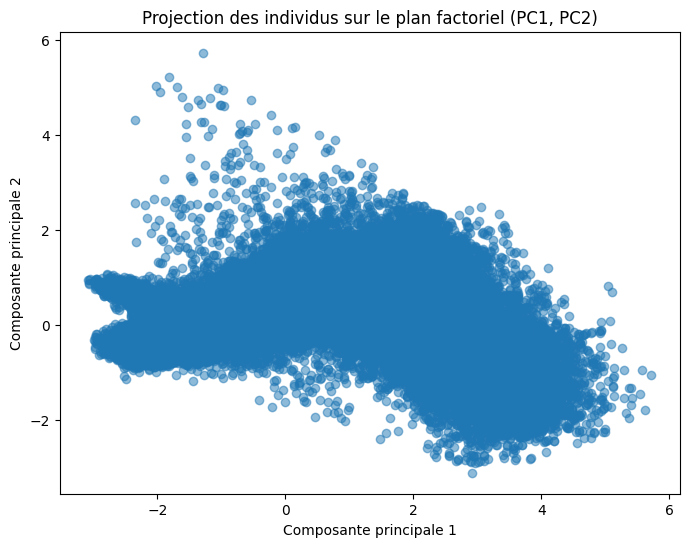

In [ ]:
# Projection des individus sur le plan factoriel (PC1, PC2)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection des individus sur le plan factoriel (PC1, PC2)')

# Optionnel: Ajouter des labels aux individus
# for i, txt in enumerate(df.index):  # Utiliser l'index du DataFrame pour les labels
#     plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))

plt.show()


Interprétation:

L'axe 1 essentiellement determiné par pCO2w, SST, SSS, Chla et aCDOM.
Il OPPOSE les variables Chla et aCDOM aux variables pCO2w, SST et SSS.
Les individus ayant de fortes coordonnées négatives sont caractérisés par des valeurs de pCO2w, SST supérieures à la moyenne et SSS très supéreures à la moyenne associées à des valeurs de Chla et aCDOM très inférieures à la moyenne.
Ces individus sont opposés aux individus à fortes coordonnées positives caractérisés par des valeurs de aCDOM et Chla très supérieures à la moyenne associées à des valeurs de pCO2w, SST inférieures à la moyenne et SSS très inférieures à la moyenne.


L'axe 2 essentiellement determiné par pCO2w et SST.
Il OPPOSE la variable pCO2w à SST.
Les individus ayant de fortes coordonnées négatives sont caractérisés par des valeurs de SST très légèrement supérieures à la moyenne associées à des valeurs de pC02w inférieures à la moyenne.
Ces individus sont opposés aux individus à fortes coordonnées positives caractérisés par des valeurs de pCO2w supérieures à la moyenne associées à des valeurs de SST légèrement inférieures à la moyenne.

On va maintenant analyser les contributions des individus pour juger de la qualité de l'ACP. Si les contributions des individus sont trop élevés par rapport aux poids, c'est un facteur d'instabilité. Il vaut mieux alors recommencer l'ACP en retirant ces individus et les rajoutant après.

Etant donné qu'on a ici trop d'observations, on va créer un programme qui permet d'afficher seulement les individus qui ont des contributions significativement supérieures aux poids. Ici on va dire qu'on a une équiprobabilité, on a 11000 individu le poids d'un inidividu est donc 0,000011. On va dire que les contributions sont significativement supérieures si elles sont supérieures à 6 fois le poids, soit 0.0055

# Contribution

---



In [ ]:
# Calcul des contributions des individus sur les composantes principales
contributions = pd.DataFrame(
    (principal_components ** 2) / np.sum(principal_components ** 2, axis=0),
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
    index=df_copy_k.index,
)

# Calculer la moyenne des contributions pour chaque composante
mean_contributions = contributions.mean(axis=0)

# Afficher la moyenne des contributions pour chaque composante
print("\nLa moyenne des contributions pour chaque composante est:\n", mean_contributions)

# Ajouter une colonne 'max_contrib' qui prend la valeur maximale de contribution pour chaque individu sur toutes les composantes
contributions['max_contrib'] = contributions.max(axis=1)

# Trier par ordre décroissant en fonction de cette colonne
contributions_sorted = contributions.sort_values(by='max_contrib', ascending=False)

# Tronquer à 10000 individus
top_10000_contributions = contributions_sorted.head(10000)

# Enregistrer les indices des 10000 individus
top_10000_indices = top_10000_contributions.index.tolist()

# Afficher les 10000 premières lignes sans troncature pour bien voir toutes les contributions
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#print("\nTop 10000 individus avec les plus grandes contributions (max contribution sur n'importe quelle composante):\n", top_10000_contributions)



La moyenne des contributions pour chaque composante est:
 PC1    0.000019
PC2    0.000019
PC3    0.000019
dtype: float64


On remarque que pour les 10 000 premiers individus, triés par ordre croissant de contribution, les contributions sont significativement élevées. Nous allons donc enregistrer les indices de ces individus dans une liste, puis recommencer l'ACP sans eux. Ensuite, nous les réintégrerons à l'analyse après coup

# Cosinus carré
La mesure locale de la qualité de la représentation d’un individu est donnée par le cosinus de l’angle entre le plan principal et le vecteur associé à l’individu.

 Si ce cosinus est élevé, cela signifie que l'individu est proche du plan et qu'il est pertinent d'examiner la position de sa projection par rapport aux autres points. En revanche, si le cosinus est faible, il convient d'éviter de tirer des conclusions à partir de cette projection.

In [ ]:

# Calcul du cosinus carré des individus sur les composantes principales
cos2 = pd.DataFrame(
    (principal_components ** 2) / (np.sum(principal_components ** 2, axis=1).reshape(-1, 1)),
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
    index=df_copy_k.index,
)

# Filtrer pour afficher les 10 individus avec les cos² les plus élevés
top_cos2 = cos2.apply(lambda x: x.nlargest(10))
print("\nTop 10 cosinus carré des individus sur les composantes principales:\n", top_cos2)


Top 10 cosinus carré des individus sur les composantes principales:
             PC1       PC2       PC3
968    0.999921       NaN       NaN
18739       NaN  0.998670       NaN
19267  0.999966       NaN       NaN
20682       NaN  0.998431       NaN
21708       NaN  0.999075       NaN
22399       NaN  0.998687       NaN
23623       NaN  0.998082       NaN
23972       NaN       NaN  0.998908
24127  0.999981       NaN       NaN
24230       NaN       NaN  0.998081
24825       NaN  0.999266       NaN
25240       NaN       NaN  0.999032
27339  0.999948       NaN       NaN
27825  0.999884       NaN       NaN
27934       NaN       NaN  0.998688
31233       NaN       NaN  0.998830
31259       NaN       NaN  0.997837
31525       NaN  0.998580       NaN
31789       NaN  0.998845       NaN
31841       NaN  0.998819       NaN
32189       NaN  0.999960       NaN
35737  0.999975       NaN       NaN
36481  0.999895       NaN       NaN
36768  0.999886       NaN       NaN
40233  0.999945       NaN     

# ACP sans les individus avec contribution forte


Valeurs propres après suppression des individus à forte contribution:
 [3.94229689 0.46525972 0.33624838 0.21896346 0.03723156]

Pourcentage d'information (variance expliquée) par composante après suppression:
 [80.04103678  8.71809863  6.15694614  4.26966532  0.81425313]


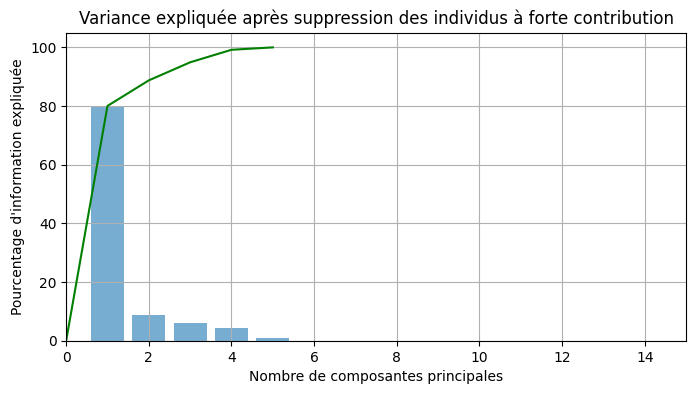

In [ ]:
# Étape 1 : Retirer les individus ayant les contributions les plus élevées
# On supprime les lignes correspondant aux indices de 'top_10000_indices'
df_filtered = df_stand.drop(index=top_10000_indices)

# Étape 2 : Effectuer une nouvelle ACP sur les données filtrées
pca_filtered = PCA()
principal_components_filtered = pca_filtered.fit_transform(df_filtered)

# Étape 3 : Extrait les nouvelles valeurs propres et vecteurs propres
eig_vals_filtered_corr, eig_vecs_filtered_corr = np.linalg.eig(np.corrcoef(df_filtered.T))
print("\nValeurs propres après suppression des individus à forte contribution:\n", eig_vals_filtered_corr)

# Étape 4 : Calculer la nouvelle variance expliquée
explained_variance_filtered = pca_filtered.explained_variance_ratio_ * 100
print("\nPourcentage d'information (variance expliquée) par composante après suppression:\n", explained_variance_filtered)

# Étape 5 : Visualisation de la nouvelle variance expliquée
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_filtered) + 1), explained_variance_filtered, alpha=0.6)
plt.plot(np.cumsum(np.array([0, *explained_variance_filtered])), color='green')
plt.xlim([0, 15])
plt.grid(True)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Pourcentage d\'information expliquée')
plt.title('Variance expliquée après suppression des individus à forte contribution')
plt.show()

# Facultatif : Vous pouvez aussi ré-enregistrer les contributions si nécessaire



Pourcentage d'information (variance expliquée):
 [80.04103678  8.71809863  6.15694614  4.26966532  0.81425313]


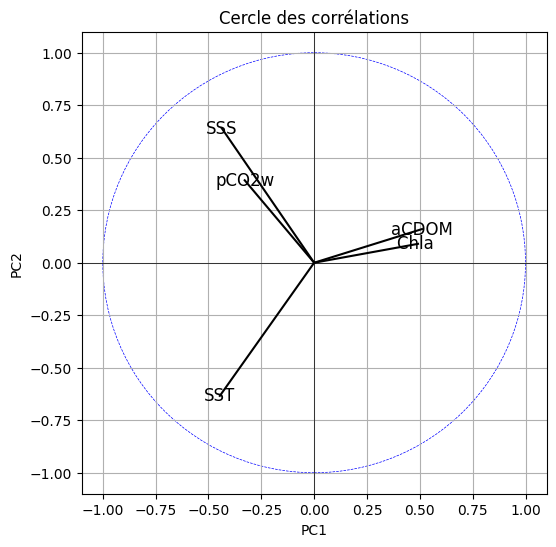

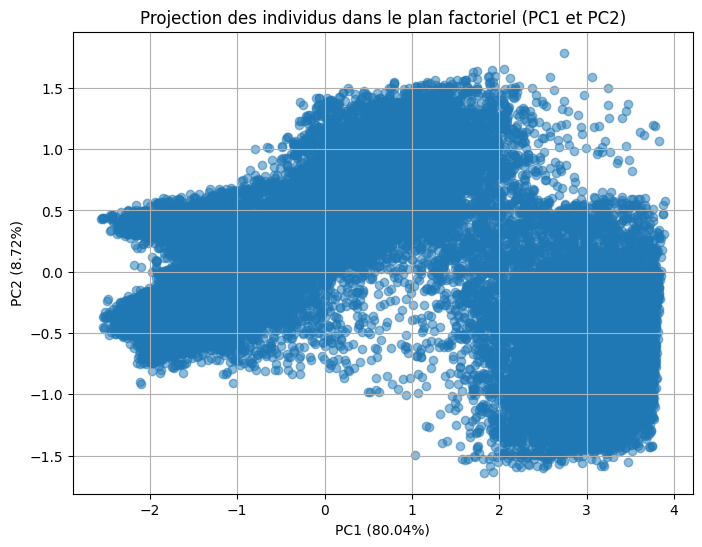

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Étape 1 : Retirer les individus ayant les contributions les plus élevées
df_filtered = df_stand.drop(index=top_10000_indices)

# Étape 2 : Effectuer une nouvelle ACP sur les données filtrées
pca_filtered = PCA()
principal_components_filtered = pca_filtered.fit_transform(df_filtered)



explained_variance_final = pca_filtered.explained_variance_ratio_ * 100
print("\nPourcentage d'information (variance expliquée):\n", explained_variance_final)

### Étape 3 : Réintégrer les individus à forte contribution ###

# Réintégrer les individus ayant les fortes contributions
df_final = pd.concat([df_filtered, df_stand.loc[top_10000_indices]])


### Étape 4 : Cercle des corrélations ###

# Calcul des contributions des variables aux axes principaux
components = pca_filtered.components_

# Cercle de corrélation : Les axes principaux sont les 2 premières composantes
fig, ax = plt.subplots(figsize=(6, 6))

# Tracer un cercle
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=0.5)
ax.add_artist(circle)

# Projection des variables dans le plan factoriel (PC1 et PC2)
for i, (x, y) in enumerate(zip(components[0, :], components[1, :])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, df_final.columns[i], fontsize=12, ha='center', va='center')

# Ajustements du graphique
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Cercle des corrélations")
plt.show()

### Étape 5 : Projection des individus dans le plan factoriel ###

# Extraction des premières composantes principales (PC1 et PC2)
pc1_final = principal_components_filtered[:, 0]
pc2_final = principal_components_filtered[:, 1]

# Projection des individus dans le plan factoriel (PC1, PC2)
plt.figure(figsize=(8, 6))
plt.scatter(pc1_final, pc2_final, alpha=0.5)
plt.title('Projection des individus dans le plan factoriel (PC1 et PC2)')
plt.xlabel('PC1 ({}%)'.format(round(explained_variance_final[0], 2)))
plt.ylabel('PC2 ({}%)'.format(round(explained_variance_final[1], 2)))
plt.grid(True)
plt.show()


In [ ]:
# prompt: Afficher tableau des corrélations des variables par rapport au deux premières composantes

# Calculer la corrélation entre les variables et les deux premières composantes principales
correlation_with_pc1 = df_stand.corrwith(pd.Series(principal_components_filtered[:, 0], index=df_filtered.index))
correlation_with_pc2 = df_stand.corrwith(pd.Series(principal_components_filtered[:, 1], index=df_filtered.index))

# Créer un DataFrame pour afficher les corrélations
correlation_table = pd.DataFrame({'PC1': correlation_with_pc1, 'PC2': correlation_with_pc2})

# Afficher le tableau des corrélations
print("\nTableau des corrélations avec les deux premières composantes principales:\n", correlation_table)


Tableau des corrélations avec les deux premières composantes principales:
             PC1       PC2
pCO2w -0.789852  0.311413
SST   -0.858055 -0.402299
SSS   -0.862469  0.417035
Chla   0.958753  0.057896
aCDOM  0.953716  0.098835




La nouvelle interprétation est:

L'axe 1 essentiellement determiné par pCO2w, SST, SSS, Chla et aCDOM.
Il OPPOSE les variables Chla et aCDOM aux variables pCO2w, SST et SSS.
Les individus ayant de fortes coordonnées négatives sont caractérisés par des valeurs de pCO2w, SST et SSS supéreures à la moyenne associées à des valeurs de Chla et aCDOM très inférieures à la moyenne.
Ces individus sont opposés aux individus à fortes coordonnées positives caractérisés par des valeurs de aCDOM et Chla très supérieures à la moyenne associées à des valeurs de pCO2w, SST et SSS inférieures à la moyenne.


L'axe 2 essentiellement determiné par SST et SSS, cependant ces variables ont des coefficients assez faibles ( d'ordre de 0.4)
Les individus ayant de fortes coordonnées négatives sont caractérisés par des valeurs de SST très légèrement supérieures à la moyenne associées à des valeurs de SSS  très légèrement inférieures à la moyenne.
Ces individus sont opposés aux individus à fortes coordonnées positives caractérisés par des valeurs de SSS très légèrement supérieures à la moyenne associées à des valeurs de SST très légèrement inférieures à la moyenne.



#Conclusion  :


Dans cette première partie du projet, nous avons commencé par effectuer un échantillonnage (sampling) de nos données afin de réduire le temps de calcul. Ensuite, nous avons procédé à un traitement des données, notamment en remplaçant les valeurs manquantes à l'aide de différentes méthodes d'imputation. Parmi celles testées, l'imputation par KNN a produit les meilleurs résultats.

Nous avons ensuite exploré la répartition des données pour chaque variable et étudié les relations entre les paires de variables. Nous avons notamment observé une forte corrélation linéaire entre deux variables, aCDOM et Chla, qui présentent des distributions similaires.

Enfin, l'analyse multidimensionnelle nous a permis de capturer des relations plus complexes entre les variables, offrant ainsi une meilleure compréhension des interactions au sein du jeu de données.